In [1]:
import sys
sys.path.append('../../')
from experiments.temperature import generate_data
from experiments.utils import create_df_from_cached_results, load_share_from_checkpoint, extract_slope_intercept
from sklearn.metrics import r2_score
from gplearn.gplearn.genetic import SymbolicRegressor
from gplearn.gplearn.model import ShapeNN
import matplotlib.pyplot as plt
import time
import torch
import pandas as pd
import numpy as np
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [2]:
# Read the timestamp from the file
with open(f'../results/Figure_7_timestamp.txt','r') as f:
    timestamp = f.read()
# Read dataframe
res_df = pd.read_csv(f'../results/Figure_7_results.csv', index_col=0)

In [3]:
res_df[res_df['n_shapes'] == 0].sort_values(by='r2_train',ascending=False).iloc[0,:]

id                     369
equation                X1
raw_fitness    9107.925781
r2               -3.913502
r2_val           -3.512664
r2_train         -3.492072
n_shapes                 0
n_variables              1
Name: 369, dtype: object

In [4]:
res_df[res_df['n_shapes'] == 1].sort_values(by='r2_train',ascending=False).iloc[0,:]

id                                     573
equation       shape(add(X2, div(X0, X1)))
raw_fitness                      61.630322
r2                                0.966752
r2_val                            0.969567
r2_train                          0.973962
n_shapes                                 1
n_variables                              3
Name: 573, dtype: object

In [5]:
res_df[res_df['n_shapes'] == 2].sort_values(by='r2_train',ascending=False).iloc[0,:]

id                                            629
equation       shape(add(shape(X2), div(X0, X1)))
raw_fitness                              2.444794
r2                                       0.998681
r2_val                                   0.998606
r2_train                                 0.998867
n_shapes                                        2
n_variables                                     3
Name: 629, dtype: object

In [6]:
res_df[res_df['n_shapes'] == 3].sort_values(by='r2_train',ascending=False).iloc[0,:]

id                                                   373
equation       shape(div(add(shape(X2), X0), shape(X1)))
raw_fitness                                    14.316096
r2                                              0.992277
r2_val                                          0.988236
r2_train                                        0.991869
n_shapes                                               3
n_variables                                            3
Name: 373, dtype: object

In [7]:
res_df[res_df['n_shapes'] == 4].sort_values(by='r2_train',ascending=False).iloc[0,:]

id                                                          201
equation       shape(div(X0, shape(mul(shape(X1), shape(X2)))))
raw_fitness                                          113.499763
r2                                                      0.93877
r2_val                                                 0.942311
r2_train                                               0.945782
n_shapes                                                      4
n_variables                                                   3
Name: 201, dtype: object

In [8]:
def evaluate_shape(shape,t):
    shape.to(torch.device('cpu'))
    t = torch.from_numpy(t).float()
    shape.eval()
    with torch.no_grad():
        return shape(t).numpy().flatten()

In [9]:
# visualize the shape functions
colors = ['#377eb8', '#ff7f00', '#4daf4a',
          '#f781bf', '#a65628', '#984ea3',
          '#999999', '#e41a1c', '#dede00']
linewidth = 2.0
alpha = 0.5
markersize = 5.0
label_fontsize = 20
ticks_fontsize = 15

In [10]:
def plot_share_1(ax,esr):
    shape_2 = esr._program.model.shape_functions[1]
    t = np.linspace(-100,0,1000)
    maxi, mini = evaluate_shape(shape_2,t).max(), evaluate_shape(shape_2,t).min()
    shape = esr._program.model.shape_functions[0]
    lower = 1 + mini
    upper = 800 + maxi
    t = np.linspace(lower,upper,1000)
    print(lower,upper)
    ax.plot(t,evaluate_shape(shape,t),c=colors[2],linewidth=linewidth, alpha=alpha, label=r"$s_1$")
    ax.set_xlabel(r'$\frac{E}{m}$ (cal/g)', fontsize=label_fontsize)
    ax.set_ylabel(r"$s_1$", fontsize=label_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=ticks_fontsize)
#     ax.legend(fontsize=15)
def plot_share_2(ax,esr):
    shape = esr._program.model.shape_functions[1]
    t = np.linspace(-100,0,1000)
    ax.plot(t,evaluate_shape(shape,t),c=colors[2],linewidth=linewidth, alpha=alpha, label=r"SHARE")
    ax.set_xlabel(r'$t_0$ ($^{\circ}$C)', fontsize=label_fontsize)
    ax.set_ylabel(r"$s_2$", fontsize=label_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=ticks_fontsize)
#     ax.legend(fontsize=15)

shape(add(shape(X2), div(X0, X1)))
shape(add(shape(X2), div(X0, X1)))
-41.07093048095703 806.3383369445801


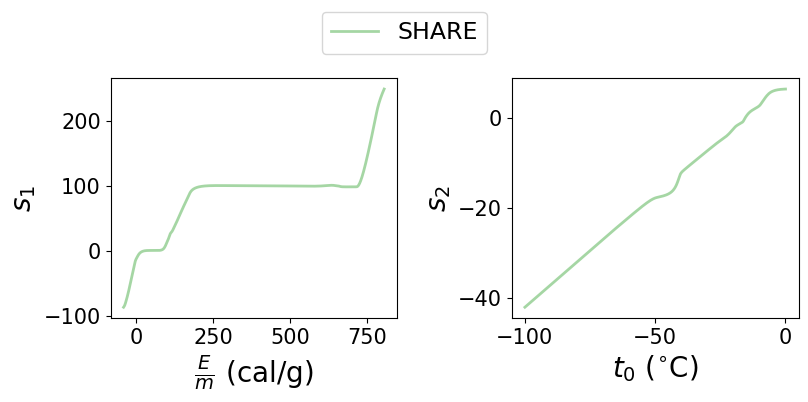

In [11]:
sorted_filtered = res_df[res_df['n_shapes'] == 2].sort_values(by='r2_train',ascending=False)
eq = sorted_filtered.iloc[0,1]
id = sorted_filtered.iloc[0,0]
print(eq)
esr = load_share_from_checkpoint(timestamp, eq, checkpoint_dir='../results/checkpoints', task='regression',n_features=3, equation_id=id)

fig, axs = plt.subplots(1,2, figsize=(8,4))
plot_share_1(axs[0],esr)
plot_share_2(axs[1],esr)

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', fontsize=17)
plt.subplots_adjust(left=0.12, bottom=0.2, right=0.98, top=0.8, wspace=0.4, hspace=None)
plt.savefig('figures/Figure_7.pdf')

In [12]:
# Fit a simple linear model to the second shape function
from sklearn.linear_model import LinearRegression

shape_2 = esr._program.model.shape_functions[1]

X = np.linspace(-100,0,1000).reshape(-1,1)
y = evaluate_shape(shape_2,X)
reg = LinearRegression().fit(X, y)

In [13]:
# Extract slope and intercept from the linear model
slope, intercept = reg.coef_[0], reg.intercept_

In [14]:
print(f'slope: {slope}, intercept: {intercept}')

slope: 0.49481451518743497, intercept: 7.393961124399311


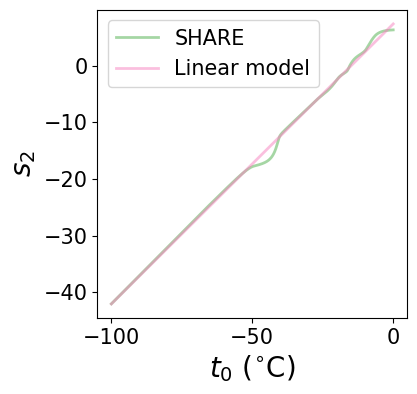

In [15]:
# Plot both the shape function and the linear model
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.plot(X,y,c=colors[2],linewidth=linewidth, alpha=alpha, label=r"SHARE")
ax.plot(X,reg.predict(X),c=colors[3],linewidth=linewidth, alpha=alpha, label=r"Linear model")
ax.set_xlabel(r'$t_0$ ($^{\circ}$C)', fontsize=label_fontsize)
ax.set_ylabel(r"$s_2$", fontsize=label_fontsize)
ax.tick_params(axis='both', which='major', labelsize=ticks_fontsize)
ax.legend(fontsize=15)

In [16]:
# Fit a piecewise linear model to the first shape function

from scipy.optimize import curve_fit

t = np.linspace(-100,0,1000)
maxi, mini = evaluate_shape(shape_2,t).max(), evaluate_shape(shape_2,t).min()
shape = esr._program.model.shape_functions[0]
lower = 1 + mini
upper = 800 + maxi

# Define the piecewise linear function with 5 segments
def piecewise_linear(x, c2, c3, c4, c5, a1, a3, a5, b1):
    a2 = 0
    a4 = 0
    return np.piecewise(x, [x < c2, (c2 <= x) & (x < c3), (c3 <= x) & (x < c4), (c4 <= x) & (x < c5), x >= c5],
                        [lambda x: a1 * x + b1, 
                         lambda x: a2 * (x-c2) + a1 * c2 + b1, 
                         lambda x: a3 * (x-c3) + a2 * (c3-c2) + a1 * c2 + b1, 
                         lambda x: a4 * (x-c4) + a3 * (c4-c3) + a2 * (c3-c2) + a1 * c2 + b1, 
                         lambda x: a5 * (x-c5) + a4 * (c5-c4) + a3 * (c4-c3) + a2 * (c3-c2) + a1 * c2 + b1])

shape_1 = esr._program.model.shape_functions[0]

x_data = np.linspace(lower,upper,1000)
y_data = evaluate_shape(shape_1,x_data)

# Initial guess for the parameters
initial_guess = [0,100,200,750,2,1,2,0]

# Fit the piecewise linear function to the data
params, covariance = curve_fit(piecewise_linear, x_data, y_data, p0=initial_guess)


In [17]:
# Extract the parameters
c2, c3, c4, c5, a1, a3, a5, b1 = params

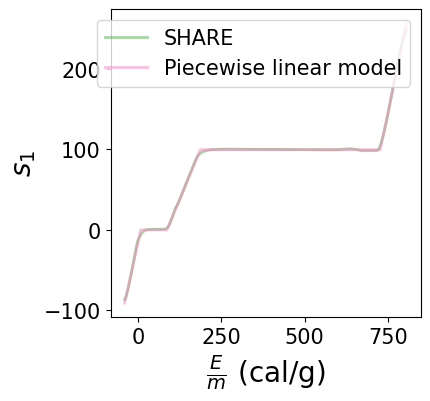

In [18]:
# Plot both the shape function and the piecewise linear model
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.plot(x_data,y_data,c=colors[2],linewidth=linewidth, alpha=alpha, label=r"SHARE")
ax.plot(x_data,piecewise_linear(x_data, *params),c=colors[3],linewidth=linewidth, alpha=alpha, label=r"Piecewise linear model")
ax.set_xlabel(r'$\frac{E}{m}$ (cal/g)', fontsize=label_fontsize)
ax.set_ylabel(r"$s_1$", fontsize=label_fontsize)
ax.tick_params(axis='both', which='major', labelsize=ticks_fontsize)
ax.legend(fontsize=15)


In [19]:
print(f"Specific heat of ice is {1/a1}")

Specific heat of ice is 0.5276218816529531


In [20]:
print(f"Specific heat of water is {1/a3}")

Specific heat of water is 1.0056097642649595


In [21]:
print(f"Specific heat of steam is {1/a5}")

Specific heat of steam is 0.4997620736425318


In [22]:
print(f"Heat of fusion is {c3-c2}")

Heat of fusion is 78.85467295306145


In [23]:
print(f"Heat of vaporization is {c5-c4}")

Heat of vaporization is 540.9059199200631
